In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**SAVE BEFORE STARTING!!!**

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
spark = SparkSession.builder.appName("Demand Forecasting").getOrCreate()

In [ ]:
train = spark.read.csv('train_file.csv', header=True)

In [ ]:
items = spark.read.csv('items.csv', header=True)

In [ ]:
store = spark.read.csv('stores.csv', header=True)
transactions = spark.read.csv('transactions.csv', header=True)

In [ ]:
holidays_events = spark.read.csv('holidays_events.csv', header=True)

In [ ]:
holidays_events = holidays_events.withColumnRenamed('type','holiday_type')

In [ ]:
transactions = transactions.withColumnRenamed('date','tdate')

In [ ]:
store.show()

+---------+-------------+--------------------+----+-------+
|store_nbr|         city|               state|type|cluster|
+---------+-------------+--------------------+----+-------+
|        1|        Quito|           Pichincha|   D|     13|
|        2|        Quito|           Pichincha|   D|     13|
|        3|        Quito|           Pichincha|   D|      8|
|        4|        Quito|           Pichincha|   D|      9|
|        5|Santo Domingo|Santo Domingo de ...|   D|      4|
|        6|        Quito|           Pichincha|   D|     13|
|        7|        Quito|           Pichincha|   D|      8|
|        8|        Quito|           Pichincha|   D|      8|
|        9|        Quito|           Pichincha|   B|      6|
|       10|        Quito|           Pichincha|   C|     15|
|       11|      Cayambe|           Pichincha|   B|      6|
|       12|    Latacunga|            Cotopaxi|   C|     15|
|       13|    Latacunga|            Cotopaxi|   C|     15|
|       14|     Riobamba|          Chimb

In [ ]:
transactions.show()

+----------+---------+------------+
|     tdate|store_nbr|transactions|
+----------+---------+------------+
|2013-01-01|       25|         770|
|2013-01-02|        1|        2111|
|2013-01-02|        2|        2358|
|2013-01-02|        3|        3487|
|2013-01-02|        4|        1922|
|2013-01-02|        5|        1903|
|2013-01-02|        6|        2143|
|2013-01-02|        7|        1874|
|2013-01-02|        8|        3250|
|2013-01-02|        9|        2940|
|2013-01-02|       10|        1293|
|2013-01-02|       11|        3547|
|2013-01-02|       12|        1362|
|2013-01-02|       13|        1102|
|2013-01-02|       14|        2002|
|2013-01-02|       15|        1622|
|2013-01-02|       16|        1167|
|2013-01-02|       17|        1580|
|2013-01-02|       18|        1635|
|2013-01-02|       19|        1369|
+----------+---------+------------+
only showing top 20 rows



In [ ]:
import pyspark.sql.functions as f
items_train = train.alias("d1").join(items.alias("d2"), f.col("d1.item_nbr") == f.col("d2.item_nbr"), "left").drop(train.item_nbr)
store_itemTrain = items_train.alias("d1").join(store.alias("d2"), f.col("d1.store_nbr") == f.col("d2.store_nbr"), "left").drop(items_train.store_nbr)


In [ ]:
# Joining Train data with items 
items_train.show()

+---+----------+---------+----------+--------+-------------+-----+----------+
| id|      date|store_nbr|unit_sales|item_nbr|       family|class|perishable|
+---+----------+---------+----------+--------+-------------+-----+----------+
|  0|2013-01-01|       25|         7|  103665| BREAD/BAKERY| 2712|         1|
|  1|2013-01-01|       25|         1|  105574|    GROCERY I| 1045|         0|
|  2|2013-01-01|       25|         2|  105575|    GROCERY I| 1045|         0|
|  3|2013-01-01|       25|         1|  108079|    GROCERY I| 1030|         0|
|  4|2013-01-01|       25|         1|  108701|         DELI| 2644|         1|
|  5|2013-01-01|       25|         3|  108786|     CLEANING| 3044|         0|
|  6|2013-01-01|       25|         1|  108797|    GROCERY I| 1004|         0|
|  7|2013-01-01|       25|         1|  108952|     CLEANING| 3024|         0|
|  8|2013-01-01|       25|        13|  111397|    GROCERY I| 1072|         0|
|  9|2013-01-01|       25|         3|  114790|    GROCERY I| 100

In [ ]:
#Train + Items + Store
store_itemTrain.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- unit_sales: string (nullable = true)
 |-- item_nbr: string (nullable = true)
 |-- family: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: string (nullable = true)



In [ ]:
store_itemTrain.show()

+---+----------+----------+--------+-------------+-----+----------+---------+-------+-----------+----+-------+
| id|      date|unit_sales|item_nbr|       family|class|perishable|store_nbr|   city|      state|type|cluster|
+---+----------+----------+--------+-------------+-----+----------+---------+-------+-----------+----+-------+
|  0|2013-01-01|         7|  103665| BREAD/BAKERY| 2712|         1|       25|Salinas|Santa Elena|   D|      1|
|  1|2013-01-01|         1|  105574|    GROCERY I| 1045|         0|       25|Salinas|Santa Elena|   D|      1|
|  2|2013-01-01|         2|  105575|    GROCERY I| 1045|         0|       25|Salinas|Santa Elena|   D|      1|
|  3|2013-01-01|         1|  108079|    GROCERY I| 1030|         0|       25|Salinas|Santa Elena|   D|      1|
|  4|2013-01-01|         1|  108701|         DELI| 2644|         1|       25|Salinas|Santa Elena|   D|      1|
|  5|2013-01-01|         3|  108786|     CLEANING| 3044|         0|       25|Salinas|Santa Elena|   D|      1|
|

In [ ]:
# from pyspark.sql.functions import *
# date_field = store_itemTrain.select('date')
# r=to_date(col("date_field"),"MM-dd-yyyy"))


In [ ]:
store_itemTrain.show(2)

+---+----------+----------+--------+------------+-----+----------+---------+-------+-----------+----+-------+
| id|      date|unit_sales|item_nbr|      family|class|perishable|store_nbr|   city|      state|type|cluster|
+---+----------+----------+--------+------------+-----+----------+---------+-------+-----------+----+-------+
|  0|2013-01-01|         7|  103665|BREAD/BAKERY| 2712|         1|       25|Salinas|Santa Elena|   D|      1|
|  1|2013-01-01|         1|  105574|   GROCERY I| 1045|         0|       25|Salinas|Santa Elena|   D|      1|
+---+----------+----------+--------+------------+-----+----------+---------+-------+-----------+----+-------+
only showing top 2 rows



In [ ]:
# from pyspark.sql.functions import *
# store_itemTrain.select("date",to_date("date","yyyy-MM-dd")).show()

In [ ]:
# store_itemTrain=store_itemTrain.select(col("id"),col("unit_sales"),col("item_nbr"),col("family"),col("family"),col("class"),col("perishable"),col("date"),col('store_nbr'),col('city'),col('state'),col('type'),col('cluster'),to_date(col("date"),"").alias("store_itemTrain_date"))

In [ ]:
store_itemTrain.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- unit_sales: string (nullable = true)
 |-- item_nbr: string (nullable = true)
 |-- family: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: string (nullable = true)



In [ ]:
df3 = store_itemTrain.alias("st").join(transactions.alias("t"),(f.col("st.store_nbr") == f.col("t.store_nbr")) & (f.col("st.date") == f.col("t.tdate")), "left").drop(store_itemTrain.store_nbr)

In [ ]:
# df3 = store_itemTrain.alias("st").join(transactions.alias("t"),f.col("st.store_nbr") == f.col("t.store_nbr"), "left").drop(store_itemTrain.store_nbr)

In [ ]:
df3=df3.drop('tdate')

In [ ]:
df3.show()

+---+----------+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+
| id|      date|unit_sales|item_nbr|       family|class|perishable|   city|      state|type|cluster|store_nbr|transactions|
+---+----------+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+
|  0|2013-01-01|         7|  103665| BREAD/BAKERY| 2712|         1|Salinas|Santa Elena|   D|      1|       25|         770|
|  1|2013-01-01|         1|  105574|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|
|  2|2013-01-01|         2|  105575|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|
|  3|2013-01-01|         1|  108079|    GROCERY I| 1030|         0|Salinas|Santa Elena|   D|      1|       25|         770|
|  4|2013-01-01|         1|  108701|         DELI| 2644|         1|Salinas|Santa Elena|   D|      1|       25|         770|
|  5|201

In [ ]:
oil = spark.read.csv('oil.csv', header=True)

In [ ]:
oil.show()

+----------+----------+
|      date|dcoilwtico|
+----------+----------+
|2013-01-01|      null|
|2013-01-02|     93.14|
|2013-01-03|     92.97|
|2013-01-04|     93.12|
|2013-01-07|      93.2|
|2013-01-08|     93.21|
|2013-01-09|     93.08|
|2013-01-10|     93.81|
|2013-01-11|      93.6|
|2013-01-14|     94.27|
|2013-01-15|     93.26|
|2013-01-16|     94.28|
|2013-01-17|     95.49|
|2013-01-18|     95.61|
|2013-01-21|      null|
|2013-01-22|     96.09|
|2013-01-23|     95.06|
|2013-01-24|     95.35|
|2013-01-25|     95.15|
|2013-01-28|     95.95|
+----------+----------+
only showing top 20 rows



In [ ]:
df4 = df3.join(oil, ['date'], 'left')

In [ ]:
df4.show()

+----------+---+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+
|      date| id|unit_sales|item_nbr|       family|class|perishable|   city|      state|type|cluster|store_nbr|transactions|dcoilwtico|
+----------+---+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+
|2013-01-01|  0|         7|  103665| BREAD/BAKERY| 2712|         1|Salinas|Santa Elena|   D|      1|       25|         770|      null|
|2013-01-01|  1|         1|  105574|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|      null|
|2013-01-01|  2|         2|  105575|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|      null|
|2013-01-01|  3|         1|  108079|    GROCERY I| 1030|         0|Salinas|Santa Elena|   D|      1|       25|         770|      null|
|2013-01-01|  4|         1|  108701|         DELI| 2644

In [ ]:
df4.printSchema()

root
 |-- date: string (nullable = true)
 |-- id: string (nullable = true)
 |-- unit_sales: string (nullable = true)
 |-- item_nbr: string (nullable = true)
 |-- family: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- transactions: string (nullable = true)
 |-- dcoilwtico: string (nullable = true)



In [ ]:
import pyspark.sql.functions as func
df4 = df4.withColumn("dcoilwtico", func.round(df4["dcoilwtico"]).cast('integer'))

In [ ]:
df4 = df4.na.fill(value=0,subset=["dcoilwtico"])

In [ ]:
df4.show()

+----------+---+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+
|      date| id|unit_sales|item_nbr|       family|class|perishable|   city|      state|type|cluster|store_nbr|transactions|dcoilwtico|
+----------+---+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+
|2013-01-01|  0|         7|  103665| BREAD/BAKERY| 2712|         1|Salinas|Santa Elena|   D|      1|       25|         770|         0|
|2013-01-01|  1|         1|  105574|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|         0|
|2013-01-01|  2|         2|  105575|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|         0|
|2013-01-01|  3|         1|  108079|    GROCERY I| 1030|         0|Salinas|Santa Elena|   D|      1|       25|         770|         0|
|2013-01-01|  4|         1|  108701|         DELI| 2644

In [ ]:
df5 = df4.join(holidays_events, ['date'], 'left')

In [ ]:
df5.show()

+----------+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+------------+--------+-----------+------------------+-----------+
|      date|unit_sales|item_nbr|       family|class|perishable|   city|      state|type|cluster|store_nbr|transactions|dcoilwtico|holiday_type|  locale|locale_name|       description|transferred|
+----------+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+------------+--------+-----------+------------------+-----------+
|2013-01-01|         7|  103665| BREAD/BAKERY| 2712|         1|Salinas|Santa Elena|   D|      1|       25|         770|         0|     Holiday|National|    Ecuador|Primer dia del ano|      False|
|2013-01-01|         1|  105574|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|         0|     Holiday|National|    Ecuador|Primer dia del ano|      False|
|2013-01-01|        

In [ ]:
df4 = df4.drop('id')

In [ ]:
#dropping id
df5=df5.drop('id') 


In [ ]:
df5.printSchema()

root
 |-- date: string (nullable = true)
 |-- unit_sales: string (nullable = true)
 |-- item_nbr: string (nullable = true)
 |-- family: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- transactions: string (nullable = true)
 |-- dcoilwtico: integer (nullable = true)
 |-- holiday_type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: string (nullable = true)



In [ ]:
from pyspark.sql.types import DateType,IntegerType
df5 = df5.withColumn("transferred",df5["transferred"].cast(IntegerType()))

In [ ]:
df5.show(2)

+----------+----------+--------+------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+------------+--------+-----------+------------------+-----------+
|      date|unit_sales|item_nbr|      family|class|perishable|   city|      state|type|cluster|store_nbr|transactions|dcoilwtico|holiday_type|  locale|locale_name|       description|transferred|
+----------+----------+--------+------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+------------+--------+-----------+------------------+-----------+
|2013-01-01|         7|  103665|BREAD/BAKERY| 2712|         1|Salinas|Santa Elena|   D|      1|       25|         770|         0|     Holiday|National|    Ecuador|Primer dia del ano|       null|
|2013-01-01|         1|  105574|   GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|         0|     Holiday|National|    Ecuador|Primer dia del ano|       null|
+----------+----------+--

In [ ]:
df5 = df5.withColumn("date", df5["date"].cast(DateType()))

In [ ]:
df5 = df5.withColumn("unit_sales", df5["unit_sales"].cast(IntegerType()))

In [ ]:
df5 = df5.na.fill(value=0,subset=["unit_sales"])

In [ ]:
df5.printSchema()

root
 |-- date: date (nullable = true)
 |-- unit_sales: integer (nullable = true)
 |-- item_nbr: string (nullable = true)
 |-- family: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- transactions: string (nullable = true)
 |-- dcoilwtico: integer (nullable = true)
 |-- holiday_type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: integer (nullable = true)



In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [ ]:
# final_df.show(5)

+----------+----------+--------+------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+------------+--------+-----------+------------------+-----------+--------+------+-------+--------------+--------+-------------+
|      date|unit_sales|item_nbr|      family|class|perishable|   city|      state|type|cluster|store_nbr|transactions|dcoilwtico|holiday_type|  locale|locale_name|       description|transferred|family_n|city_n|state_n|holiday_type_n|locale_n|locale_name_n|
+----------+----------+--------+------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+------------+--------+-----------+------------------+-----------+--------+------+-------+--------------+--------+-------------+
|2013-01-01|         7|  103665|BREAD/BAKERY| 2712|         1|Salinas|Santa Elena|   D|      1|       25|         770|         0|     Holiday|National|    Ecuador|Primer dia del ano|       null|     5.0|  10.0|    9.0|           

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler

In [ ]:
from pyspark.ml.feature import OneHotEncoder

In [ ]:
# Spark Pipeline
# cat_features = ['family', 'city', 'state', 'locale','locale_name','type']
# num_features = ['date','item_nbr','item_nbr','class','perishable','store_nbr','transactions','dcoilwtico','transferred']

cat_features = ['family', 'city', 'state','type']
num_features = ['item_nbr','item_nbr','class','perishable','store_nbr','transactions','dcoilwtico']
label = 'unit_sales'

# Pipeline Stages List
stages = []

# Loop for StringIndexer and OHE for Categorical Variables
for features in cat_features:
    
    # Index Categorical Features
    string_indexer = StringIndexer(inputCol=features, outputCol=features + "_index")
    string_indexer=string_indexer.setHandleInvalid("skip")
    
    #One Hot Encode Categorical Features
    encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()],
                                     outputCols=[features + "_class_vec"])
    # Append Pipeline Stages
    stages += [string_indexer, encoder]
    
# Index Label Feature
label_str_index =  StringIndexer(inputCol=label, outputCol="label_index")

# Assemble or Concat the Categorical Features and Numeric Features
assembler_inputs = [feature + "_class_vec" for feature in cat_features] + num_features

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features") 

stages += [label_str_index, assembler]




In [ ]:
stages

[StringIndexer_d757df0926da,
 OneHotEncoder_cfbce86b705b,
 StringIndexer_1a8cfc00e3d6,
 OneHotEncoder_81e51b248857,
 StringIndexer_f23f7d8e1b18,
 OneHotEncoder_3fec4f7fecfd,
 StringIndexer_24e7fe4e8c36,
 OneHotEncoder_4b636bf66117,
 StringIndexer_da92cd37cd53,
 VectorAssembler_9832778ce6b5]

In [ ]:
from pyspark.ml import Pipeline

# Set Pipeline
pipeline = Pipeline(stages=stages)

# Fit Pipeline to Data
pipeline_model = pipeline.fit(df5)

# Transform Data using Fitted Pipeline
df_transform = pipeline_model.transform(df5)


In [ ]:
df_transform.limit(5).toPandas()

,date,id,unit_sales,item_nbr,family,class,perishable,city,state,type,...,family_index,family_class_vec,city_index,city_class_vec,state_index,state_class_vec,type_index,type_class_vec,label_index,features
0,2013-01-01,0,7,103665,BREAD/BAKERY,2712,1,Salinas,Santa Elena,D,...,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,2013-01-01,1,1,105574,GROCERY I,1045,0,Salinas,Santa Elena,D,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2013-01-01,2,2,105575,GROCERY I,1045,0,Salinas,Santa Elena,D,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2013-01-01,3,1,108079,GROCERY I,1030,0,Salinas,Santa Elena,D,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2013-01-01,4,1,108701,DELI,2644,1,Salinas,Santa Elena,D,...,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='label_index', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)

In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 15.448984
r2: 0.100596


In [ ]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","label_index","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label_index",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+-----------+--------------------+
|       prediction|label_index|            features|
+-----------------+-----------+--------------------+
|8.723401309919344|        0.0|(58,[0,20,38,52,5...|
|8.723401309919344|        0.0|(58,[0,20,38,52,5...|
|8.723401309919344|        0.0|(58,[0,20,38,52,5...|
|8.723401309919344|        0.0|(58,[0,20,38,52,5...|
|8.723401309919344|        0.0|(58,[0,20,38,52,5...|
+-----------------+-----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.104402


Time Series Forecasting - Analysis + Facebook Prophet Model


In [ ]:
from pyspark.sql.types import DateType,TimestampType
df4 = df4.withColumn("date", df4["date"].cast(TimestampType()))
df4 = df4.withColumn("unit_sales", func.round(df4["unit_sales"]).cast("integer"))

In [ ]:
df4 = df4.withColumn("item_nbr", func.round(df4["item_nbr"]).cast("integer"))
df4 = df4.withColumn("store_nbr", func.round(df4["store_nbr"]).cast("integer"))
df4 = df4.withColumn("transactions", func.round(df4["transactions"]).cast("integer"))
df4 = df4.withColumn("cluster", func.round(df4["cluster"]).cast("integer"))
df4 = df4.withColumn("perishable", func.round(df4["perishable"]).cast("integer"))
df4 = df4.withColumn("class", func.round(df4["class"]).cast("integer"))

In [ ]:
df4.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- unit_sales: integer (nullable = true)
 |-- item_nbr: integer (nullable = true)
 |-- family: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- transactions: integer (nullable = true)
 |-- dcoilwtico: integer (nullable = true)



In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
indexer = StringIndexer(inputCol='family', outputCol='family_t').fit(df4)
indexed_df = indexer.transform(df4)

In [ ]:
indexer = StringIndexer(inputCol='city', outputCol='city_t').fit(indexed_df)
indexed_df1 = indexer.transform(indexed_df)

In [ ]:
indexer = StringIndexer(inputCol='state', outputCol='state_t').fit(indexed_df1)
final_df = indexer.transform(indexed_df1)

In [ ]:
indexer = StringIndexer(inputCol='type', outputCol='type_t').fit(final_df)
final_df = indexer.transform(final_df)

In [ ]:
final_df.show()

+-------------------+---+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+--------+------+-------+------+
|               date| id|unit_sales|item_nbr|       family|class|perishable|   city|      state|type|cluster|store_nbr|transactions|dcoilwtico|family_t|city_t|state_t|type_t|
+-------------------+---+----------+--------+-------------+-----+----------+-------+-----------+----+-------+---------+------------+----------+--------+------+-------+------+
|2013-01-01 00:00:00|  0|         7|  103665| BREAD/BAKERY| 2712|         1|Salinas|Santa Elena|   D|      1|       25|         770|         0|     5.0|  10.0|    9.0|   0.0|
|2013-01-01 00:00:00|  1|         1|  105574|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|         770|         0|     0.0|  10.0|    9.0|   0.0|
|2013-01-01 00:00:00|  2|         2|  105575|    GROCERY I| 1045|         0|Salinas|Santa Elena|   D|      1|       25|      

In [ ]:
final_df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- unit_sales: integer (nullable = true)
 |-- item_nbr: integer (nullable = true)
 |-- family: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- transactions: integer (nullable = true)
 |-- dcoilwtico: integer (nullable = true)
 |-- family_t: double (nullable = false)
 |-- city_t: double (nullable = false)
 |-- state_t: double (nullable = false)
 |-- type_t: double (nullable = false)



In [ ]:
cols = ['id', 'family', 'city', 'state']
final_df =final_df.drop('id', 'family', 'city', 'state', 'type')

In [ ]:
final_df1 = final_df.withColumn("date", final_df["date"].cast("string"))

In [ ]:
assembler=VectorAssembler().setInputCols(['item_nbr','class','family_t','type_t', 'store_nbr','perishable', 'state_t', 'city_t', 'dcoilwtico', 'transactions']).setOutputCol('features')


In [ ]:
output_12 = assembler.transform(final_df1)

In [ ]:
output_12.show()

+----+----------+--------+-----+----------+-------+---------+------------+----------+--------+------+-------+------+--------------------+
|date|unit_sales|item_nbr|class|perishable|cluster|store_nbr|transactions|dcoilwtico|family_t|city_t|state_t|type_t|            features|
+----+----------+--------+-----+----------+-------+---------+------------+----------+--------+------+-------+------+--------------------+
|null|         7|  103665| 2712|         1|      1|       25|         770|         0|     5.0|  10.0|    9.0|   0.0|[103665.0,2712.0,...|
|null|         1|  105574| 1045|         0|      1|       25|         770|         0|     0.0|  10.0|    9.0|   0.0|[105574.0,1045.0,...|
|null|         2|  105575| 1045|         0|      1|       25|         770|         0|     0.0|  10.0|    9.0|   0.0|[105575.0,1045.0,...|
|null|         1|  108079| 1030|         0|      1|       25|         770|         0|     0.0|  10.0|    9.0|   0.0|[108079.0,1030.0,...|
|null|         1|  108701| 2644|  

In [ ]:
pandasDF = final_df.toPandas()

In [ ]:
pandasDF

,date,id,unit_sales,item_nbr,family,class,perishable,city,state,type,cluster,store_nbr,transactions,dcoilwtico,family_t,city_t,state_t
0,2013-01-01,0,7,103665,BREAD/BAKERY,2712,1,Salinas,Santa Elena,D,1,25,770,0,5.0,10.0,9.0
1,2013-01-01,1,1,105574,GROCERY I,1045,0,Salinas,Santa Elena,D,1,25,770,0,0.0,10.0,9.0
2,2013-01-01,2,2,105575,GROCERY I,1045,0,Salinas,Santa Elena,D,1,25,770,0,0.0,10.0,9.0
3,2013-01-01,3,1,108079,GROCERY I,1030,0,Salinas,Santa Elena,D,1,25,770,0,0.0,10.0,9.0
4,2013-01-01,4,1,108701,DELI,2644,1,Salinas,Santa Elena,D,1,25,770,0,4.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2013-01-27,1048570,31,956013,GROCERY I,1088,0,Quito,Pichincha,A,14,48,3977,0,0.0,0.0,0.0
1048571,2013-01-27,1048571,57,956014,GROCERY I,1088,0,Quito,Pichincha,A,14,48,3977,0,0.0,0.0,0.0
1048572,2013-01-27,1048572,6,957096,DAIRY,2130,1,Quito,Pichincha,A,14,48,3977,0,3.0,0.0,0.0
1048573,2013-01-27,1048573,4,957098,DAIRY,2130,1,Quito,Pichincha,A,14,48,3977,0,3.0,0.0,0.0


In [ ]:
item_df = pandasDF.set_index('date')

In [ ]:
item_df.drop(['id', 'family', 'city', 'state'], axis=1, inplace=True)

In [ ]:
item_df

,unit_sales,item_nbr,class,perishable,type,cluster,store_nbr,transactions,dcoilwtico,family_t,city_t,state_t
date,,,,,,,,,,,,
2013-01-01,7,103665,2712,1,D,1,25,770,0,5.0,10.0,9.0
2013-01-01,1,105574,1045,0,D,1,25,770,0,0.0,10.0,9.0
2013-01-01,2,105575,1045,0,D,1,25,770,0,0.0,10.0,9.0
2013-01-01,1,108079,1030,0,D,1,25,770,0,0.0,10.0,9.0
2013-01-01,1,108701,2644,1,D,1,25,770,0,4.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-27,31,956013,1088,0,A,14,48,3977,0,0.0,0.0,0.0
2013-01-27,57,956014,1088,0,A,14,48,3977,0,0.0,0.0,0.0
2013-01-27,6,957096,2130,1,A,14,48,3977,0,3.0,0.0,0.0


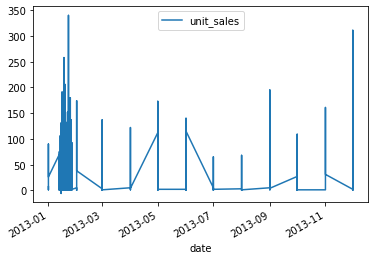

In [ ]:
import matplotlib.pyplot as plt
item_df.query('store_nbr == 25')[['unit_sales']].plot()
plt.show()

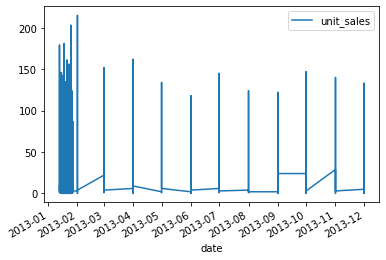

In [ ]:
item_df.query('store_nbr == 2')[['unit_sales']].plot()
plt.show()

In [ ]:
final_df.show()

+-------------------+----------+--------+-----+----------+----+-------+---------+------------+----------+--------+------+-------+
|               date|unit_sales|item_nbr|class|perishable|type|cluster|store_nbr|transactions|dcoilwtico|family_t|city_t|state_t|
+-------------------+----------+--------+-----+----------+----+-------+---------+------------+----------+--------+------+-------+
|2013-01-01 00:00:00|         7|  103665| 2712|         1|   D|      1|       25|         770|         0|     5.0|  10.0|    9.0|
|2013-01-01 00:00:00|         1|  105574| 1045|         0|   D|      1|       25|         770|         0|     0.0|  10.0|    9.0|
|2013-01-01 00:00:00|         2|  105575| 1045|         0|   D|      1|       25|         770|         0|     0.0|  10.0|    9.0|
|2013-01-01 00:00:00|         1|  108079| 1030|         0|   D|      1|       25|         770|         0|     0.0|  10.0|    9.0|
|2013-01-01 00:00:00|         1|  108701| 2644|         1|   D|      1|       25|         

In [ ]:
final_df.select(['store_nbr']).groupby('store_nbr').agg({'store_nbr': 'count'}).show()

+---------+----------------+
|store_nbr|count(store_nbr)|
+---------+----------------+
|       31|           20456|
|       34|           21343|
|       28|           20593|
|       26|           19286|
|       27|           23829|
|       44|           32203|
|       12|           17521|
|       47|           31623|
|        1|           24212|
|       13|           16269|
|        6|           28736|
|       16|           18253|
|        3|           31016|
|       40|           17375|
|       54|           14338|
|       48|           28898|
|        5|           26338|
|       19|           16032|
|       41|           21980|
|       15|           17771|
+---------+----------------+
only showing top 20 rows



In [ ]:
final_df.createOrReplaceTempView("unit_sales")
spark.sql("select store_nbr, count(*) from unit_sales group by store_nbr order by store_nbr").show()

+---------+--------+
|store_nbr|count(1)|
+---------+--------+
|        1|   24212|
|        2|   27526|
|        3|   31016|
|        4|   26580|
|        5|   26338|
|        6|   28736|
|        7|   26694|
|        8|   30156|
|        9|   25311|
|       10|   16558|
|       11|   23283|
|       12|   17521|
|       13|   16269|
|       14|   17362|
|       15|   17771|
|       16|   18253|
|       17|   18927|
|       18|   21628|
|       19|   16032|
|       23|   23075|
+---------+--------+
only showing top 20 rows



In [ ]:
sql = "SELECT store_nbr, date as ds, sum(unit_sales) as y FROM unit_sales GROUP BY store_nbr, ds ORDER BY store_nbr, ds"
spark.sql(sql).show()

+---------+-------------------+----+
|store_nbr|                 ds|   y|
+---------+-------------------+----+
|        1|2013-01-13 00:00:00|2695|
|        1|2013-01-14 00:00:00|5652|
|        1|2013-01-15 00:00:00|5208|
|        1|2013-01-16 00:00:00|6735|
|        1|2013-01-17 00:00:00|4941|
|        1|2013-01-18 00:00:00|5922|
|        1|2013-01-19 00:00:00|5898|
|        1|2013-01-20 00:00:00|2371|
|        1|2013-01-21 00:00:00|5229|
|        1|2013-01-22 00:00:00|5301|
|        1|2013-01-23 00:00:00|6257|
|        1|2013-01-24 00:00:00|4860|
|        1|2013-01-25 00:00:00|5576|
|        1|2013-01-26 00:00:00|5291|
|        1|2013-01-27 00:00:00|2443|
|        1|2013-02-01 00:00:00|7416|
|        1|2013-03-01 00:00:00|5877|
|        1|2013-04-01 00:00:00|5919|
|        1|2013-05-01 00:00:00|6318|
|        1|2013-06-01 00:00:00|2201|
+---------+-------------------+----+
only showing top 20 rows



In [ ]:
store_partition = (spark.sql(sql).repartition(spark.sparkContext.defaultParallelism, ['store_nbr'])).cache()
store_partition.explain()

== Physical Plan ==
InMemoryTableScan [store_nbr#1498, ds#2640, y#2641L]
   +- InMemoryRelation [store_nbr#1498, ds#2640, y#2641L], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_nbr#1498, 2), REPARTITION_BY_NUM, [plan_id=11503]
            +- *(6) HashAggregate(keys=[store_nbr#1498, date#1453], functions=[sum(unit_sales#1468)])
               +- Exchange hashpartitioning(store_nbr#1498, date#1453, 200), ENSURE_REQUIREMENTS, [plan_id=11499]
                  +- *(5) HashAggregate(keys=[store_nbr#1498, date#1453], functions=[partial_sum(unit_sales#1468)])
                     +- *(5) Project [cast(cast(date#18 as date) as timestamp) AS date#1453, cast(round(cast(unit_sales#21 as double), 0) as int) AS unit_sales#1468, cast(round(cast(store_nbr#97 as double), 0) as int) AS store_nbr#1498]
                        +- *(5) BroadcastHashJoin [date#18], [date#639], LeftOuter, BuildRight, false
                           :- *(5) Project [date#1

In [ ]:
from pyspark.sql.types import *
result_schema = StructType([
                  StructField('ds', TimestampType()),
                  StructField('store_nbr', IntegerType()),
                  StructField('y', DoubleType()),
                  StructField('yhat', DoubleType()),
                  StructField('yhat_upper', DoubleType()),
                  StructField('yhat_lower', DoubleType())
])

In [ ]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from prophet import Prophet
@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_sales(store_pd):
  model = Prophet(interval_width=0.95, seasonality_mode= 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)
  model.fit(store_pd)
  future_pd = model.make_future_dataframe(periods=5, freq='w')
  forecast_pd = model.predict(future_pd)
  f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
  st_pd = store_pd[['ds', 'store_nbr', 'y']].set_index('ds')
  result_pd = f_pd.join(st_pd, how='left')
  result_pd.reset_index(level=0, inplace=True)
  result_pd['store_nbr'] = store_pd['store_nbr'].iloc[0]
  return result_pd[['ds', 'store_nbr', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [ ]:
from pyspark.sql.functions import current_date
results = (store_partition.groupby('store_nbr').apply(forecast_sales))
results.cache()
results.show()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/group_ops.py:98: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



+-------------------+---------+-------+------------------+------------------+------------------+
|                 ds|store_nbr|      y|              yhat|        yhat_upper|        yhat_lower|
+-------------------+---------+-------+------------------+------------------+------------------+
|2013-01-13 00:00:00|        2|10028.0| 9889.817919558755|10132.845851543845|  9639.71227146574|
|2013-01-14 00:00:00|        2| 5963.0| 6264.312425101016| 6514.282262251256| 6013.667971233259|
|2013-01-15 00:00:00|        2| 5839.0| 5810.659478560737| 6059.153863597482| 5549.416449159284|
|2013-01-16 00:00:00|        2| 7144.0|6925.0181008192485| 7179.388668266316| 6685.752774376709|
|2013-01-17 00:00:00|        2| 5705.0| 5640.869208989423| 5875.593761518979| 5395.194276291137|
|2013-01-18 00:00:00|        2| 7439.0| 7525.513327394732| 7773.641633751039| 7284.055700329183|
|2013-01-19 00:00:00|        2| 8905.0| 9091.278702476797| 9334.760818297893| 8842.052452892445|
|2013-01-20 00:00:00|        2

In [ ]:
results.coalesce(1)
print(results.count())
results.createOrReplaceTempView('forecasted')
spark.sql("SELECT store_nbr, count(*) FROM  forecasted GROUP BY store_nbr").show()

1423
+---------+--------+
|store_nbr|count(1)|
+---------+--------+
|       31|      31|
|       28|      31|
|       12|      31|
|       13|      31|
|        5|      31|
|       37|      31|
|        4|      31|
|       49|      30|
|       10|      31|
|       50|      30|
|       45|      31|
|       38|      31|
|       25|      32|
|       32|      31|
|       14|      31|
|        2|      31|
|       46|      31|
|       18|      31|
|       34|      31|
|       26|      31|
+---------+--------+
only showing top 20 rows



ROLLING WINDOW AVERAGE

In [ ]:
rdf = final_df.withColumn('rolling_average', f.avg("unit_sales").over(Window.partitionBy(f.window("date", "7 days"))))

In [ ]:
rdf.select('rolling_average').where('store_nbr == 48').show()

+----------------+
| rolling_average|
+----------------+
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
|8.53073148946464|
+----------------+
only showing top 20 rows



Decision Tree Regressor

In [ ]:
train, test = final_df.randomSplit([0.8,0.2],1234)

In [ ]:
assembler=VectorAssembler().setInputCols(['unit_sales','item_nbr','class','family_t','type_t', 'item_nbr']).setOutputCol('features')
train_a1 = assembler.transform(train)
train_b=train_a1.select("features",train_a1.unit_sales.alias('label'))
test_a = assembler.transform(test)
test_b = test_a.select('features', test_a.unit_sales.alias('label'))

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt1 = DecisionTreeRegressor(labelCol="label", featuresCol="features")
model1 = dt1.fit(train_b)
test_dt = model1.transform(test_b)
test_dt.show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[1.0,115611.0,101...|    1|0.9904470588235295|
|[1.0,165551.0,112...|    1|0.9904470588235295|
|[1.0,172343.0,100...|    1|0.9904470588235295|
|[1.0,179600.0,100...|    1|0.9904470588235295|
|[1.0,227111.0,250...|    1|0.9904470588235295|
|[1.0,308916.0,300...|    1|0.9904470588235295|
|[1.0,315322.0,108...|    1|0.9904470588235295|
|[1.0,414888.0,309...|    1|0.9904470588235295|
|[1.0,428488.0,303...|    1|0.9904470588235295|
|[1.0,462673.0,104...|    1|0.9904470588235295|
|[1.0,521818.0,105...|    1|0.9904470588235295|
|[1.0,577745.0,103...|    1|0.9904470588235295|
|[1.0,586969.0,100...|    1|0.9904470588235295|
|[1.0,683722.0,106...|    1|0.9904470588235295|
|[1.0,723210.0,212...|    1|0.9904470588235295|
|[1.0,732006.0,264...|    1|0.9904470588235295|
|[1.0,743496.0,222...|    1|0.9904470588235295|
|[1.0,789224.0,304...|    1|0.9904470588

In [ ]:
evaluator = RegressionEvaluator()
print(" -------------- R2 Score -----------------")
print("R2 :", evaluator.evaluate(test_dt,
{evaluator.metricName: "r2"})
)
print(" -------------- RMSE Score -----------------")
print("RMSE :",evaluator.evaluate(test_dt,
{evaluator.metricName: "rmse"})
)
print(" -------------- MAE Score -----------------")
print("MAE :",evaluator.evaluate(test_dt,
{evaluator.metricName: "mae"})
)

 -------------- R2 Score -----------------
R2 : 0.5139418285971802
 -------------- RMSE Score -----------------
RMSE : 12.984215908045982
 -------------- MAE Score -----------------
MAE : 1.2035073627016069


In [ ]:
#Random Forest 
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Create an initial RandomForest model.
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

# Evaluate model
rfevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")

# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(rf.maxDepth, [2, 5, 10])
             #.addGrid(rf.maxBins, [10, 20, 40, 80, 100])
              #  .addGrid(rf.maxBins, [5, 10, 20])
             #.addGrid(rf.numTrees, [5, 20, 50, 100, 500])
               .addGrid(rf.numTrees, [5, 15, 30])
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 6)

# Run cross validations.
rfcvModel = rfcv.fit(train_b)

In [ ]:
# print(rfcvModel)

# Use test set here so we can measure the accuracy of our model on new data
rfpredictions = rfcvModel.transform(test_b)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('RMSE:', rfevaluator.evaluate(rfpredictions))

RMSE: 12.032086952511243


In [ ]:
rfpredictions.show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[1.0,115611.0,101...|    1| 4.009435927142518|
|[1.0,165551.0,112...|    1| 3.298435041089273|
|[1.0,172343.0,100...|    1|3.3404295036669027|
|[1.0,179600.0,100...|    1| 3.960007618641417|
|[1.0,227111.0,250...|    1|2.7026030991118817|
|[1.0,308916.0,300...|    1|2.0256115975712894|
|[1.0,315322.0,108...|    1|2.7018844713944077|
|[1.0,414888.0,309...|    1|2.1839823842713972|
|[1.0,428488.0,303...|    1|2.1821360962831173|
|[1.0,462673.0,104...|    1|2.4575267619421015|
|[1.0,521818.0,105...|    1| 2.605984466141395|
|[1.0,577745.0,103...|    1| 2.452084545163481|
|[1.0,586969.0,100...|    1|3.3868641053114237|
|[1.0,683722.0,106...|    1|2.5683029086193074|
|[1.0,723210.0,212...|    1| 2.756807246218227|
|[1.0,732006.0,264...|    1|1.8540489352699558|
|[1.0,743496.0,222...|    1|  2.54619592933044|
|[1.0,789224.0,304...|    1|2.5955185468

In [ ]:
test_data = spark.read.csv('test.csv', header=True)

In [ ]:
test_data.show()

+---------+----------+---------+--------+-----------+
|       id|      date|store_nbr|item_nbr|onpromotion|
+---------+----------+---------+--------+-----------+
|125497040|2017-08-16|        1|   96995|      False|
|125497041|2017-08-16|        1|   99197|      False|
|125497042|2017-08-16|        1|  103501|      False|
|125497043|2017-08-16|        1|  103520|      False|
|125497044|2017-08-16|        1|  103665|      False|
|125497045|2017-08-16|        1|  105574|      False|
|125497046|2017-08-16|        1|  105575|      False|
|125497047|2017-08-16|        1|  105576|      False|
|125497048|2017-08-16|        1|  105577|      False|
|125497049|2017-08-16|        1|  105693|      False|
|125497050|2017-08-16|        1|  105737|      False|
|125497051|2017-08-16|        1|  105857|      False|
|125497052|2017-08-16|        1|  106716|      False|
|125497053|2017-08-16|        1|  108079|      False|
|125497054|2017-08-16|        1|  108634|      False|
|125497055|2017-08-16|      

In [ ]:
test_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- item_nbr: string (nullable = true)
 |-- onpromotion: string (nullable = true)



In [ ]:
test_data = test_data.withColumn("item_nbr", func.round(test_data["item_nbr"]).cast("integer"))
test_data = test_data.withColumn("store_nbr", func.round(test_data["store_nbr"]).cast("integer"))

In [ ]:
assembler=VectorAssembler().setInputCols(['item_nbr', 'store_nbr']).setOutputCol('features')
test_a = assembler.transform(test_data)
test_b1 = test_a.select('features')

In [ ]:
dt = DecisionTreeRegressor(labelCol="label", featuresCol="features")
model = dt.fit(train_b)
test_dt1 = model.transform(test_b1)
